We need to make a file with all pairwise combinations to get our predictions. We also need to be able to turn this into a matrix later.

In [6]:
def read_phenotypes(filename):
    filepath = "" + filename
    with open(filepath, "r") as file:
        phenotypes = [line.rstrip("\n") for line in file]
    return phenotypes


TCRs = read_phenotypes("real_sample_TCRs.txt")
peptides = read_phenotypes("real_sample_peptides.txt")

In [19]:
import numpy as np

pairs = [[(TCR, pep) for TCR in TCRs] for pep in peptides]

In [24]:
missing = "<MIS>"

def get_row_dict_from_pair(pair):
    row_dict = {}
    row_dict["CDR3b"] = pair[0]
    row_dict["CDR3a"] = missing
    row_dict["peptide"] = pair[1]
    row_dict["MHC"] = missing
    row_dict["binder"] = 1

    return row_dict


In [29]:
import pandas as pd

row_list = []
for blom in pairs:
    for pair in blom:
        row_dict = get_row_dict_from_pair(pair)
        row_list.append(row_dict)

input = pd.DataFrame(row_list)
# input = pd.DataFrame(columns=["CDR3b","CDR3a","peptide","MHC","binder"])
input.to_csv("../data/input_5.csv")


Now that the predictor has been run, let us create our simulation input: the binding probability matrix

(array([248.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([2.46470378e-25, 1.62433792e-15, 3.24867584e-15, 4.87301376e-15,
        6.49735168e-15, 8.12168960e-15, 9.74602752e-15, 1.13703654e-14,
        1.29947034e-14, 1.46190413e-14, 1.62433792e-14]),
 <BarContainer object of 10 artists>)

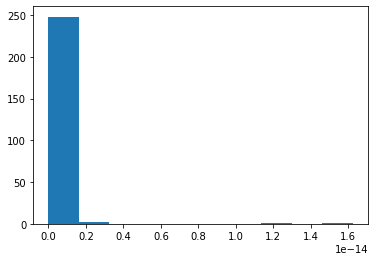

In [2]:
import pandas as pd
import numpy as np
from plotting import get_unique_output

output = pd.read_csv("../output/" + get_unique_output("5"))
tulip_unscaled_probs = np.exp(output["score"])

import matplotlib.pyplot as plt

from binding_affinity_derivation import fit_params_and_get_pbind_from_tulip_probs

kplus = 21.4
kminus = 0.015

# tulip_unscaled_probs = 10000000000000 * tulip_unscaled_probs
# tulip_unscaled_probs = [prob for prob in tulip_unscaled_probs if prob > 0.0001]

plt.hist(tulip_unscaled_probs)

(array([248.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([2.46470378e-25, 1.62433792e-15, 3.24867584e-15, 4.87301376e-15,
        6.49735168e-15, 8.12168960e-15, 9.74602752e-15, 1.13703654e-14,
        1.29947034e-14, 1.46190413e-14, 1.62433792e-14]),
 <BarContainer object of 10 artists>)

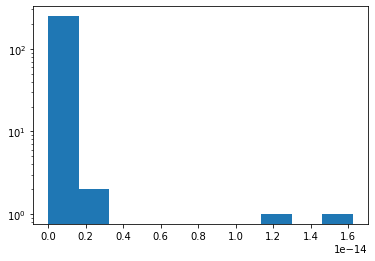

In [15]:
plt.hist(tulip_unscaled_probs, log=True)

(array([ 6., 37., 43., 20., 22., 26., 41., 36., 16.,  5.]),
 array([-56.66255569, -54.17140923, -51.68026276, -49.18911629,
        -46.69796982, -44.20682335, -41.71567688, -39.22453041,
        -36.73338394, -34.24223747, -31.751091  ]),
 <BarContainer object of 10 artists>)

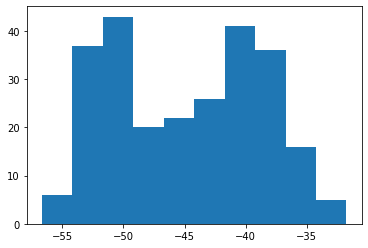

In [17]:
plt.hist(output["score"])

In [4]:
pminus = min(tulip_unscaled_probs)
pplus = max(tulip_unscaled_probs)
pminus

2.4647037809436003e-25

1.624337919328897e-14
2.4647037809436003e-25
0.29155636129594886
1.4312853975843774e-06


(array([32., 39., 19., 14.,  6., 13., 12., 23., 43., 51.]),
 array([0.04464286, 0.13870074, 0.23275862, 0.3268165 , 0.42087438,
        0.51493227, 0.60899015, 0.70304803, 0.79710591, 0.89116379,
        0.98522167]),
 <BarContainer object of 10 artists>)

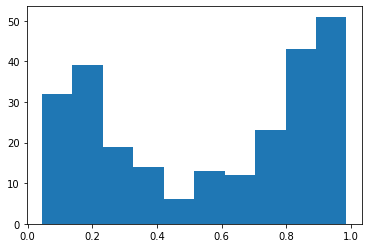

In [20]:
from binding_affinity_derivation import fit_params, get_pbind_from_tulip_probs

pminus = max(tulip_unscaled_probs)
pplus = min(tulip_unscaled_probs)
print(pminus)
print(pplus)

eta, eta_tilde = fit_params(kplus, kminus, pplus, pminus)
print(eta)
print(eta_tilde)
alt_pbinds = get_pbind_from_tulip_probs(tulip_unscaled_probs, eta, eta_tilde, 1)
plt.hist(alt_pbinds)

This stuff is correct, but it looks like the choice of thingy is quite important (do we _expect_ these two peaks? Sort of maybe, but it's really not clear from the initial distribution, or even its log)

In [12]:
get_pbind_from_tulip_probs(min(tulip_unscaled_probs), eta, eta_tilde, 1)

0.04464285714285712

In [13]:
get_pbind_from_tulip_probs(max(tulip_unscaled_probs), eta, eta_tilde, 1)

0.9852216748768474

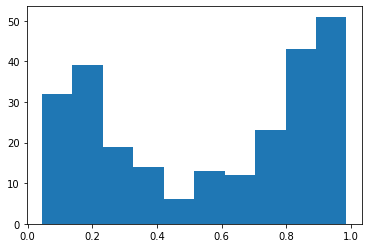

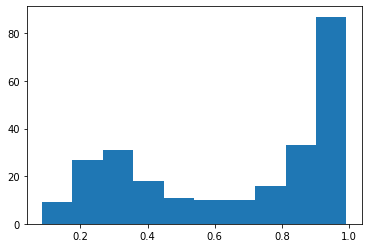

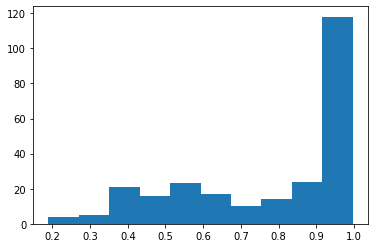

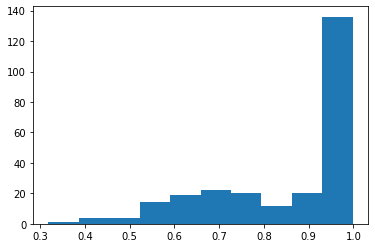

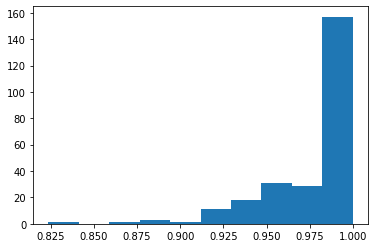

In [23]:
values = [1,2,5,10,100]

for value in values:
    alt_pbinds = get_pbind_from_tulip_probs(tulip_unscaled_probs, eta, eta_tilde, value)
    plt.hist(alt_pbinds)
    plt.show()

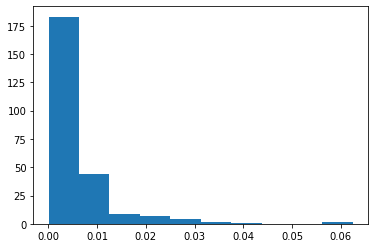

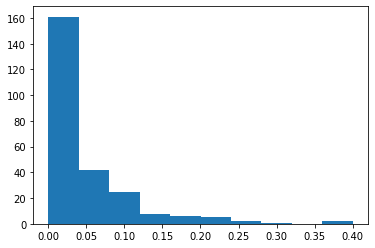

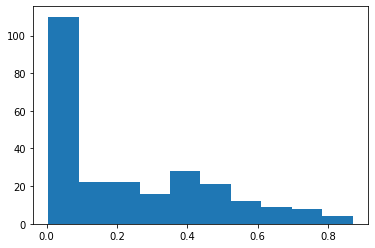

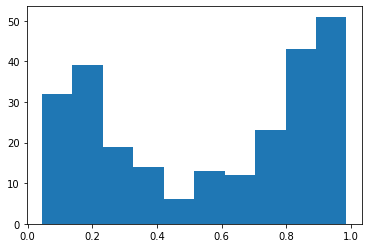

In [26]:
values = [0.001,0.01,0.1,1]

for value in values:
    alt_pbinds = get_pbind_from_tulip_probs(tulip_unscaled_probs, eta, eta_tilde, value)
    plt.hist(alt_pbinds)
    plt.show()

(array([107.,  24.,  15.,  10.,  12.,  17.,  24.,  25.,  12.,   6.]),
 array([0.00465116, 0.09114257, 0.17763397, 0.26412538, 0.35061678,
        0.43710819, 0.5235996 , 0.610091  , 0.69658241, 0.78307381,
        0.86956522]),
 <BarContainer object of 10 artists>)

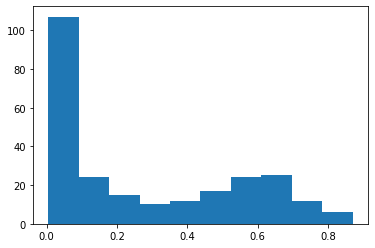

In [7]:
pbinds = fit_params_and_get_pbind_from_tulip_probs(tulip_unscaled_probs, kplus, kminus, 0.1) # This is truly wrong because we have a reversal of where the probabilites go, and eta < 0
plt.hist(pbinds)

Let us try switching `kplus` and `kminus`

As we increase T_conc, the distribution becomes more spread.

In [4]:
n = 100 

output.loc[0]

receptor_number                  0
CDR3a                        <MIS>
CDR3b              CASSLHWGLSEKLFF
peptide                  LGSPGDAGL
score                   -39.831116
rank                             8
binder                           1
Name: 0, dtype: object